<a href="https://colab.research.google.com/github/marco-montesdeoca/Differential_expression/blob/main/Differential_expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Differential expression analysis of K. pneumoniae <br>
In this notebook we will analyze RNAseq reads obtained from the pathogenic bacterium K. pneumoniae from [this project](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA548557). A subsample of these reads have already been processed as follows: <br>
1. Reads mapping to reference genome 
2. Sort mapped reads by genomic position
3. Count the number of reads corresponding to each gene


This notebook focuses on statistical analysis (differential expression).

### Install required packages <br>
For differential expression analysis we will use the [DESeq2](http://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html) tool.

In [5]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.16 (BiocManager 1.30.20), R 4.2.3 (2023-03-15)

Installing package(s) 'BiocVersion', 'DESeq2'

also installing the dependencies ‘bitops’, ‘formatR’, ‘plogr’, ‘png’, ‘Biostrings’, ‘RCurl’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘lambda.r’, ‘futile.options’, ‘XML’, ‘xtable’, ‘RSQLite’, ‘KEGGREST’, ‘GenomeInfoDb’, ‘XVector’, ‘MatrixGenerics’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘annotate’, ‘AnnotationDbi’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘matrixStats’, ‘locfit’, ‘geneplotter’, ‘Rcpp’, ‘RcppArmadillo’


Old packages: 'bit', 'bslib', 'devtools', 'digest', 'gert', 'ggplot2', 'highr',
  'isoband', 'jsonlite', 'pkgload', 

In [6]:
# This cell installs a tool used during the generation of volcano plots
install.packages("ggrepel")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [7]:
library("DESeq2")

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: M

### Data <br>
The following links can be used to get and upload to this colab session the reads count data, as well as the metadata indicating the condition of each sample. We also get the names of the genes as a summary table, generated from the gff genome annotation file. <br>
1. https://github.com/marco-montesdeoca/Differential_expression/raw/main/counts_re.csv
2. https://github.com/marco-montesdeoca/Differential_expression/raw/main/coldata.csv
3. https://github.com/marco-montesdeoca/Differential_expression/raw/main/names_genes.csv


Once the files are uploaded, we can continue with the analysis.

### Statistical analysis (differential expression)<br>

In [8]:
cts <- as.matrix(read.csv('counts_re.csv',row.names=1, sep = "\t"))
head(cts)

,PBT2R1,PBT2R2,PBT2R3,Ctrl1,Ctrl2,Ctrl3
gene-KPHS_00010,0,3,2,3,4,4
gene-KPHS_00020,1,2,1,1,1,0
gene-KPHS_00030,12,17,15,13,11,12
gene-KPHS_00040,2,2,1,1,4,2
gene-KPHS_00050,3,5,4,4,5,7
gene-KPHS_00060,0,1,3,3,5,10


We see that it is a table where the first column indicates the accession of the gene (this will be corrected soon). The following columns indicate the count of readings for each sample. The first three samples are replicates of the **PBT2** treatment condition, and the last three samples are replicates of the **control** condition. <br>
<br>
Now we open the metadata table, used to indicate which condition each sample corresponds to:

In [9]:
coldata <- read.csv('coldata.csv', row.names=1)
coldata

,condition
,<chr>
PBT2R1,PBT2
PBT2R2,PBT2
PBT2R3,PBT2
Ctrl1,Ctrl
Ctrl2,Ctrl
Ctrl3,Ctrl


The read count table and metadata can be summarized in a single object, which will then be used by DESeq2:

In [10]:
dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design = ~ condition)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


We must eliminate the rows that have less than 10 accounts, and normalize the data.

In [11]:
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]

In [12]:
dds <- estimateSizeFactors(dds)
norm <- counts(dds, normalized = TRUE)

Next we perform the differential expression analysis:

In [13]:
dds_res <- DESeq(dds)
res <- results(dds_res, contrast=c("condition","PBT2","Ctrl"))

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [14]:
# This cell orders the results by p-value.
res_ordered <- res[order(res$pvalue),]

The following cell shows the first six rows of the results ordered by p-value:

In [15]:
head(res_ordered)

log2 fold change (MLE): condition PBT2 vs Ctrl 
Wald test p-value: condition PBT2 vs Ctrl 
DataFrame with 6 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat      pvalue
                <numeric>      <numeric> <numeric> <numeric>   <numeric>
gene-KPHS_49890   28.9981       4.217750  0.565029   7.46466 8.35165e-14
gene-KPHS_02190  185.7702      -1.170998  0.171707  -6.81977 9.11892e-12
gene-KPHS_06220   20.7999       2.330551  0.477360   4.88217 1.04927e-06
gene-KPHS_16760  106.3058      -0.979530  0.209781  -4.66929 3.02241e-06
gene-KPHS_51400   56.2783      -1.043353  0.261421  -3.99109 6.57711e-05
gene-KPHS_15720  129.4788       0.671289  0.186475   3.59988 3.18361e-04
                       padj
                  <numeric>
gene-KPHS_49890 2.73934e-11
gene-KPHS_02190 1.49550e-09
gene-KPHS_06220 1.14720e-04
gene-KPHS_16760 2.47838e-04
gene-KPHS_51400 4.31458e-03
gene-KPHS_15720 1.74037e-02

To identify gene names with significant expression changes, we'll use the names_genes.csv table that includes their names. This table was obtained from the GFF genome annotation files.

In [16]:
results = list(gene = rownames(res),
                  log2FC = res$log2FoldChange,
                  nlogp = -log10(res$pvalue))
results = as.data.frame(results)

In [17]:
names <- read.csv('names_genes.csv')
for (row in 1:nrow(results)) {
  id_ = results[row, "gene"]
  gene = names$gene[names$ID == id_]
  results[row, 'gene'] = gene
}

Finally, we can represent the differential expression results in a Volcano plot:

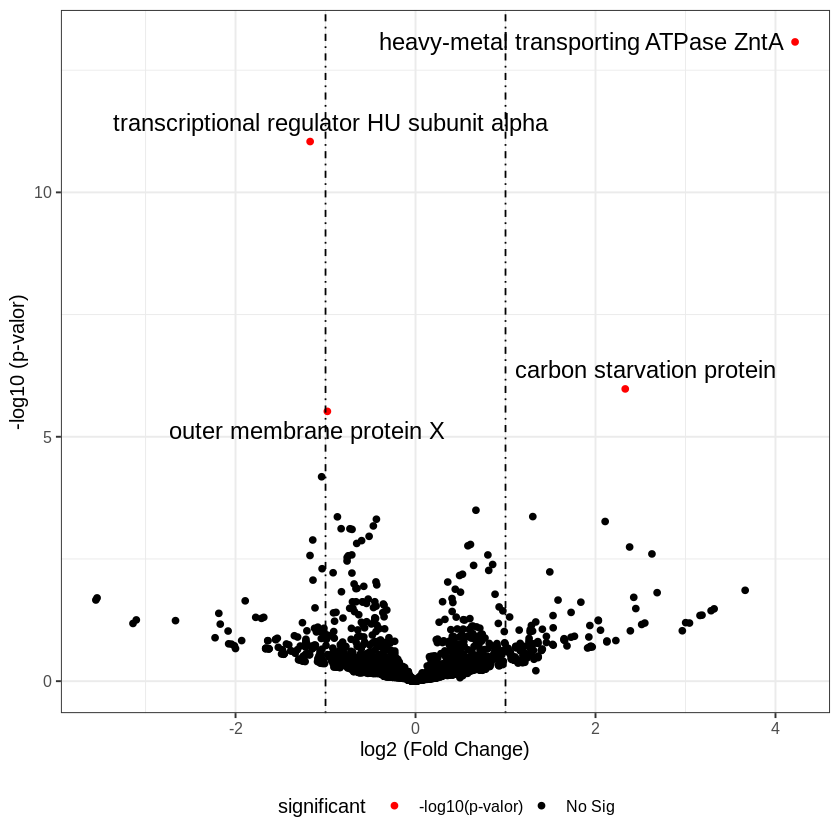

In [18]:
library('ggplot2')
library('ggrepel')
results$significant <- ifelse(results$nlogp >= 5, "-log10(p-valor)", "No Sig")
plot = ggplot(results, aes(x = log2FC, y = nlogp)) +
  geom_point(aes(color = significant)) +
  scale_color_manual(values = c("red", "black")) +
  theme_bw(base_size = 12) + theme(legend.position = "bottom") +
  geom_text_repel(
    data = subset(results, nlogp >= 5),
    aes(label = gene),
    size = 5,
    box.padding = unit(0.35, "lines"),
    point.padding = unit(0.3, "lines")
  )
plot + labs(x = "log2 (Fold Change)", y = "-log10 (p-valor)") + geom_vline(xintercept = -1, linetype="dotdash") + geom_vline(xintercept = 1, linetype="dotdash")

From the **Volcano plot**, and considering that the **ratio of change** used in the differential expression analysis is equal to (Treatment Condition / Control Condition), <br>
1. The heavy-metal transporting ATPase ZntA and carbon starvation protein genes have a significant increase in expression (in the treatment condition compared to the control).
2. The transcriptional regulator HU subunit alpha and outer membrane protein X genes have a significant decrease (in the treatment condition compared to the control).

We must remember that these results come from a subsample of the original reads.